In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text and Formatting
import arabic_reshaper
from bidi.algorithm import get_display

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Hierarchical Clustering
import scipy.cluster.hierarchy as shc

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Evaluation and Utilities
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report

# Other Utilities
import requests
import warnings
import os

# Suppress warnings
warnings.filterwarnings("ignore")

# Summary

In this project, we aim to develop a recommendation system for investment funds tailored to users' preferences, risk tolerance, and performance goals. The system leverages advanced data analysis and machine learning techniques to provide personalized and accurate recommendations. By analyzing user input and historical fund performance data, we aim to enhance decision-making for both novice and experienced investors.

# Data Loading and Preparation
<hr style="border:1px solid gray">

In [2]:
urls = [
    'https://data.gov.il/api/3/action/datastore_search?resource_id=a66926f3-e396-4984-a4db-75486751c2f7&limit=30000',
    'https://data.gov.il/api/3/action/datastore_search?resource_id=4694d5a7-5284-4f3d-a2cb-5887f43fb55e&limit=30000',
    'https://data.gov.il/api/3/action/datastore_search?resource_id=6d47d6b5-cb08-488b-b333-f1e717b1e1bd&limit=30000'
]

def fetch_api_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        json_data = response.json()
        return pd.DataFrame(json_data['result']['records'])
    else:
        print(f"Failed to fetch data from {url}, status code: {response.status_code}")
        return pd.DataFrame()

The data used in this project is sourced from publicly available datasets provided by the Israeli government, offering comprehensive financial and investment fund information.

In [4]:
# Fetch and combine data 
dataframes = [fetch_api_data(url) for url in urls]
df = pd.concat(dataframes, ignore_index=True)

In [5]:
df.head(3)

,_id,FUND_ID,FUND_NAME,PARENT_COMPANY_ID,PARENT_COMPANY_NAME,FUND_CLASSIFICATION,CONTROLLING_CORPORATION,MANAGING_CORPORATION,REPORT_PERIOD,INCEPTION_DATE,...,STANDARD_DEVIATION,ALPHA,SHARPE_RATIO,LIQUID_ASSETS_PERCENT,STOCK_MARKET_EXPOSURE,FOREIGN_EXPOSURE,FOREIGN_CURRENCY_EXPOSURE,MANAGING_CORPORATION_LEGAL_ID,REPORTING_YEAR,CURRENT_DATE
0,1,475,איילון פיסגה כללית עד 50,657,איילון פיסגה כללית,קרנות כלליות,איילון אחזקות,"איילון פנסיה וגמל בע""מ",201606,42556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,513741017,2016.0,NaN
1,2,475,איילון פיסגה כללית עד 50,657,איילון פיסגה כללית,קרנות כלליות,איילון אחזקות,"איילון פנסיה וגמל בע""מ",201607,42556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,513741017,2016.0,NaN
2,3,475,איילון פיסגה כללית עד 50,657,איילון פיסגה כללית,קרנות כלליות,איילון אחזקות,"איילון פנסיה וגמל בע""מ",201608,42556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,513741017,2016.0,NaN


In [6]:
unique_values_list = sorted(df['REPORT_PERIOD'].unique())
#print(unique_values_list)
#Note: Data is only available from late 2011 onward, despite the source claiming availability from 1999.

# EDA - Exploratory Data Analysis
<hr style="border:1px solid gray">

In [7]:
df.isnull().sum().sort_values()

_id                                   0
FUND_ID                               0
FUND_NAME                             0
PARENT_COMPANY_ID                     0
PARENT_COMPANY_NAME                   0
FUND_CLASSIFICATION                   0
CONTROLLING_CORPORATION               0
MANAGING_CORPORATION                  0
REPORT_PERIOD                         0
INCEPTION_DATE                        0
MANAGING_CORPORATION_LEGAL_ID         0
TOTAL_ASSETS                          0
MONTHLY_YIELD                       881
AVG_ANNUAL_MANAGEMENT_FEE          1407
AVG_DEPOSIT_FEE                    1791
YEAR_TO_DATE_YIELD                 2311
REPORTING_YEAR                     2916
INTERNAL_TRANSFERS                 5176
WITHDRAWLS                         5176
DEPOSITS                           5176
NET_MONTHLY_DEPOSITS               5176
LIQUID_ASSETS_PERCENT              5272
FOREIGN_CURRENCY_EXPOSURE          5287
FOREIGN_EXPOSURE                   5298
STOCK_MARKET_EXPOSURE              5305


Given the numerical and highly variable nature of the data (pension funds), columns with over 60% missing values are likely to lead to unreliable imputations, so they are dropped to ensure data accuracy.

In [8]:
#threshold = 0.6- more than 60% missing values->drop
missing_percentage = df.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage > 0.6].index
print(list(columns_to_drop))

['ACTUARIAL_ADJUSTMENT', 'ALPHA', 'CURRENT_DATE']


ALPHA has more than 60% missing values but is a key financial metric that measures a fund's performance compared to the expected return based on market trends- We will handle it's missing values in a moment.

Also removing columns that are not directly relevant to our goal of building a recommendation system for fund optimization-

In [9]:
columns_to_drop = ['MANAGING_CORPORATION_LEGAL_ID', 'MANAGING_CORPORATION', 
    'CONTROLLING_CORPORATION', 'INTERNAL_TRANSFERS', 
    'WITHDRAWLS', 'DEPOSITS', 'NET_MONTHLY_DEPOSITS', 'LIQUID_ASSETS_PERCENT', 
    'FOREIGN_CURRENCY_EXPOSURE', 'FOREIGN_EXPOSURE', 'STOCK_MARKET_EXPOSURE', 
    'YIELD_TRAILING_3_YRS', 'YIELD_TRAILING_5_YRS', 
    'AVG_ANNUAL_YIELD_TRAILING_3YRS', 'AVG_ANNUAL_YIELD_TRAILING_5YRS', 
    'ACTUARIAL_ADJUSTMENT', 'CURRENT_DATE']
df = df.drop(columns=columns_to_drop, axis=1)

#### Filling Missing Values 

In [10]:
#INCEPTION_DATE column contains dates in various formats- standardizing them to a consistent datetime format-
#Handling Excel-based dates
df['INCEPTION_DATE_NUMERIC'] = pd.to_numeric(df['INCEPTION_DATE'], errors='coerce')
df['INCEPTION_DATE_CONVERTED'] = pd.to_datetime(df['INCEPTION_DATE_NUMERIC'], origin='1900-01-01', unit='D', errors='coerce')
#Handling text-based dates
df['INCEPTION_DATE_TEXT'] = pd.to_datetime(df['INCEPTION_DATE'], format='%d/%m/%Y', dayfirst=True, errors='coerce')
#Handling ISO format dates
df['INCEPTION_DATE_ISO'] = pd.to_datetime(df['INCEPTION_DATE'], errors='coerce')
df['INCEPTION_DATE'] = (df['INCEPTION_DATE_CONVERTED'].combine_first(df['INCEPTION_DATE_TEXT']).combine_first(df['INCEPTION_DATE_ISO']))
df = df.drop(columns=['INCEPTION_DATE_NUMERIC', 'INCEPTION_DATE_CONVERTED', 'INCEPTION_DATE_TEXT', 'INCEPTION_DATE_ISO'])
#print(df['INCEPTION_DATE'].isnull().sum()) #0

#Converting REPORT_PERIOD to datetime
df['REPORT_PERIOD'] = pd.to_datetime(df['REPORT_PERIOD'], format='%Y%m', errors='coerce')
df['REPORT_PERIOD'] = df['REPORT_PERIOD'].dt.strftime('%m/%Y')
#print(df['REPORT_PERIOD'].isnull().sum()) #0


# Filling missing values in REPORTING_YEAR using the year from REPORT_PERIOD
df['REPORT_PERIOD_YEAR'] = pd.to_datetime(df['REPORT_PERIOD'], format='%m/%Y', errors='coerce').dt.year
df['REPORTING_YEAR'] = df['REPORTING_YEAR'].fillna(df['REPORT_PERIOD_YEAR']).astype(int)  
df.drop(columns=['REPORT_PERIOD_YEAR'], inplace=True)

#print(df['REPORTING_YEAR'].isnull().sum()) #0

In [11]:
df.isnull().sum().sort_values()

_id                              0
INCEPTION_DATE                   0
REPORT_PERIOD                    0
FUND_CLASSIFICATION              0
TOTAL_ASSETS                     0
PARENT_COMPANY_ID                0
FUND_NAME                        0
FUND_ID                          0
PARENT_COMPANY_NAME              0
REPORTING_YEAR                   0
MONTHLY_YIELD                  881
AVG_ANNUAL_MANAGEMENT_FEE     1407
AVG_DEPOSIT_FEE               1791
YEAR_TO_DATE_YIELD            2311
STANDARD_DEVIATION           14834
SHARPE_RATIO                 14903
ALPHA                        15038
dtype: int64

In [12]:
# MONTHLY_YIELD: Group mean (FUND_CLASSIFICATION, REPORTING_YEAR), fallback to global mean
df['MONTHLY_YIELD'] = df.groupby(['FUND_CLASSIFICATION', 'REPORTING_YEAR'])['MONTHLY_YIELD'].transform(lambda x: x.fillna(x.mean()))
df['MONTHLY_YIELD'] = df['MONTHLY_YIELD'].fillna(df['MONTHLY_YIELD'].mean())

# YEAR_TO_DATE_YIELD: Group mean (FUND_CLASSIFICATION, REPORTING_YEAR), fallback to global mean
df['YEAR_TO_DATE_YIELD'] = df.groupby(['FUND_CLASSIFICATION', 'REPORTING_YEAR'])['YEAR_TO_DATE_YIELD'].transform(lambda x: x.fillna(x.mean()))
df['YEAR_TO_DATE_YIELD'] = df['YEAR_TO_DATE_YIELD'].fillna(df['YEAR_TO_DATE_YIELD'].mean())

# AVG_ANNUAL_MANAGEMENT_FEE: Group mean (FUND_CLASSIFICATION, REPORTING_YEAR), fallback to global mean
df['AVG_ANNUAL_MANAGEMENT_FEE'] = df.groupby(['FUND_CLASSIFICATION', 'REPORTING_YEAR'])['AVG_ANNUAL_MANAGEMENT_FEE'].transform(lambda x: x.fillna(x.mean()))
df['AVG_ANNUAL_MANAGEMENT_FEE'] = df['AVG_ANNUAL_MANAGEMENT_FEE'].fillna(df['AVG_ANNUAL_MANAGEMENT_FEE'].mean())

# AVG_DEPOSIT_FEE: Group mean (FUND_CLASSIFICATION, REPORTING_YEAR), fallback to global mean
df['AVG_DEPOSIT_FEE'] = df.groupby(['FUND_CLASSIFICATION', 'REPORTING_YEAR'])['AVG_DEPOSIT_FEE'].transform(lambda x: x.fillna(x.mean()))
df['AVG_DEPOSIT_FEE'] = df['AVG_DEPOSIT_FEE'].fillna(df['AVG_DEPOSIT_FEE'].mean())

# SHARPE_RATIO: Group mean (FUND_CLASSIFICATION, REPORTING_YEAR), fallback to global mean
df['SHARPE_RATIO'] = df.groupby(['FUND_CLASSIFICATION', 'REPORTING_YEAR'])['SHARPE_RATIO'].transform(lambda x: x.fillna(x.mean()))
df['SHARPE_RATIO'] = df['SHARPE_RATIO'].fillna(df['SHARPE_RATIO'].mean())

# STANDARD_DEVIATION: Group mean (FUND_CLASSIFICATION, REPORTING_YEAR), fallback to global mean
df['STANDARD_DEVIATION'] = df.groupby(['FUND_CLASSIFICATION', 'REPORTING_YEAR'])['STANDARD_DEVIATION'].transform(lambda x: x.fillna(x.mean()))
df['STANDARD_DEVIATION'] = df['STANDARD_DEVIATION'].fillna(df['STANDARD_DEVIATION'].mean())

ALPHA-

We will evaluate two methods for handling missing ALPHA values-

The first method will involve simple imputation by filling missing values with the mean of the ALPHA column. 

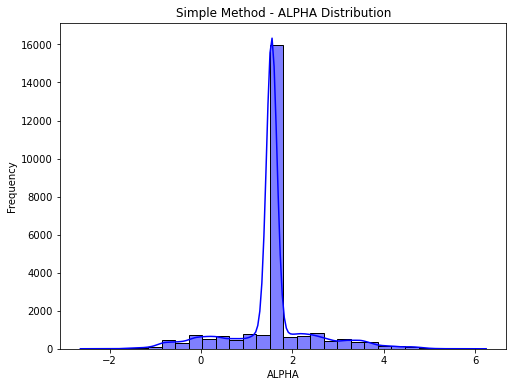

count    24971.000000
mean         1.547569
std          0.867092
min         -2.640000
25%          1.547569
50%          1.547569
75%          1.547569
max          6.240000
Name: ALPHA, dtype: float64


In [13]:
#Simple Method - Filling missing ALPHA with the mean
df_simple = df.copy()
alpha_mean = df_simple['ALPHA'].mean()
df_simple['ALPHA'] = df_simple['ALPHA'].fillna(alpha_mean)

plt.figure(figsize=(8, 6))
sns.histplot(df_simple['ALPHA'], bins=30, kde=True, color='blue')
plt.title("Simple Method - ALPHA Distribution")
plt.xlabel("ALPHA")
plt.ylabel("Frequency")
plt.show()
print(df_simple['ALPHA'].describe())

The second method will use a financial formula based on MONTHLY_YIELD, SHARPE_RATIO, and STANDARD_DEVIATION to calculate missing ALPHA values.

ALPHA=r 
p
​
 −[r 
f
​
 +β⋅(r 
m
​
 −r 
f
​
 )]+w 
1
​
 ⋅SHARPE_RATIO−w 
2
​
 ⋅STANDARD_DEVIATION

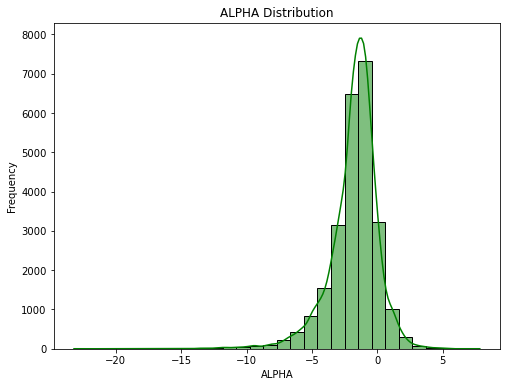

count    24971.000000
mean        -1.780886
std          1.917627
min        -23.200000
25%         -2.568524
50%         -1.515478
75%         -0.697617
max          7.847521
Name: ALPHA, dtype: float64


In [14]:
#Assisted by AI#
#Defining constants for ALPHA calculation
risk_free_rate = 0.01  
market_return = 0.07   
beta = 1               
w1 = 0.3               
w2 = 0.5               

#Calculating ALPHA using the formula
df['ALPHA'] = (df['MONTHLY_YIELD'] - (risk_free_rate + beta * (market_return - risk_free_rate)) +w1 * df['SHARPE_RATIO'] - w2 * df['STANDARD_DEVIATION'])

plt.figure(figsize=(8, 6))
sns.histplot(df['ALPHA'], bins=30, kde=True, color='green')
plt.title("ALPHA Distribution")
plt.xlabel("ALPHA")
plt.ylabel("Frequency")
plt.show()
print(df['ALPHA'].describe())

The advanced method provides a more accurate and insightful representation of the data, making it the preferred choice for handling missing ALPHA values.

This approach ensured data completeness, maintained analytical integrity, and avoided biases from excluding records with missing values.

להבנה שלנו- השיטה המתקדמת שומרת על המשמעות הפיננסית של כל קרן ויוצרת התפלגות רחבה ואמיתית יותר בעוד שהשיטה הפשוטה ממלאת ערכים חסרים בממוצע העמודה, מה שיוצר ערך קבוע וחסר משמעות עבור קרנות שונות 

In [14]:
df.isnull().sum().sort_values()

_id                          0
ALPHA                        0
STANDARD_DEVIATION           0
YEAR_TO_DATE_YIELD           0
MONTHLY_YIELD                0
AVG_DEPOSIT_FEE              0
AVG_ANNUAL_MANAGEMENT_FEE    0
SHARPE_RATIO                 0
TOTAL_ASSETS                 0
REPORT_PERIOD                0
FUND_CLASSIFICATION          0
PARENT_COMPANY_NAME          0
PARENT_COMPANY_ID            0
FUND_NAME                    0
FUND_ID                      0
INCEPTION_DATE               0
REPORTING_YEAR               0
dtype: int64

We have completed missing value imputation and data cleaning and can now proceed to the next stage- Visualization.

In [15]:
df.head(3)

,_id,FUND_ID,FUND_NAME,PARENT_COMPANY_ID,PARENT_COMPANY_NAME,FUND_CLASSIFICATION,REPORT_PERIOD,INCEPTION_DATE,TOTAL_ASSETS,AVG_ANNUAL_MANAGEMENT_FEE,AVG_DEPOSIT_FEE,MONTHLY_YIELD,YEAR_TO_DATE_YIELD,STANDARD_DEVIATION,ALPHA,SHARPE_RATIO,REPORTING_YEAR
0,1,475,איילון פיסגה כללית עד 50,657,איילון פיסגה כללית,קרנות כלליות,06/2016,2016-07-07,0.37,0.66,2.36,-0.80,1.3257,4.724821,-3.047011,0.618,2016
1,2,475,איילון פיסגה כללית עד 50,657,איילון פיסגה כללית,קרנות כלליות,07/2016,2016-07-07,0.43,0.66,2.36,2.10,1.3257,4.724821,-0.147011,0.618,2016
2,3,475,איילון פיסגה כללית עד 50,657,איילון פיסגה כללית,קרנות כלליות,08/2016,2016-07-07,0.80,0.66,2.36,-0.47,1.3257,4.724821,-2.717011,0.618,2016


#### Data Visualization

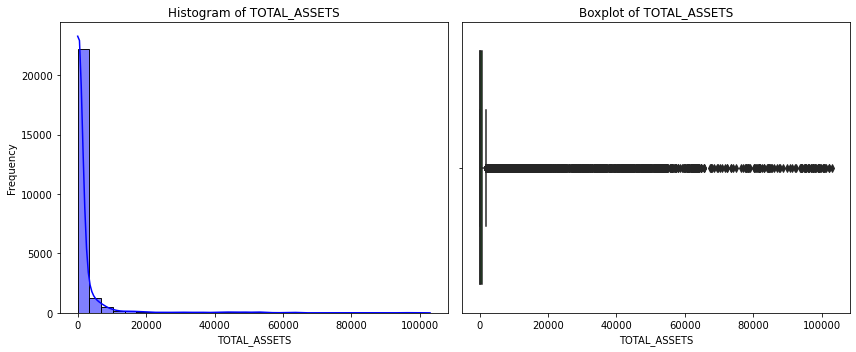

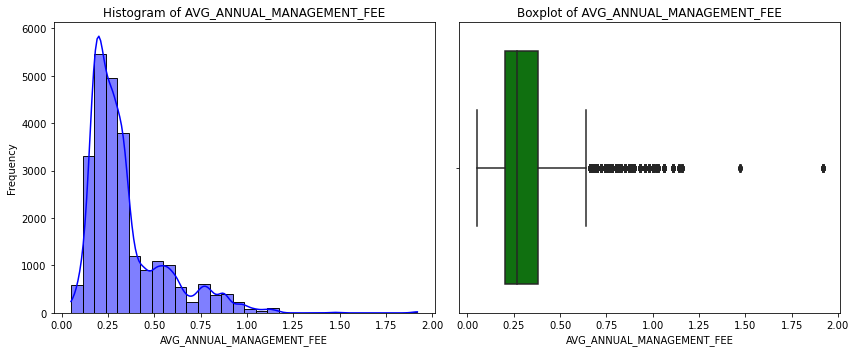

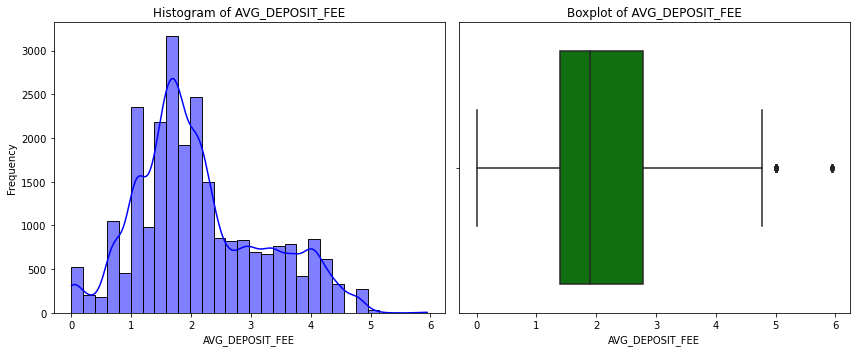

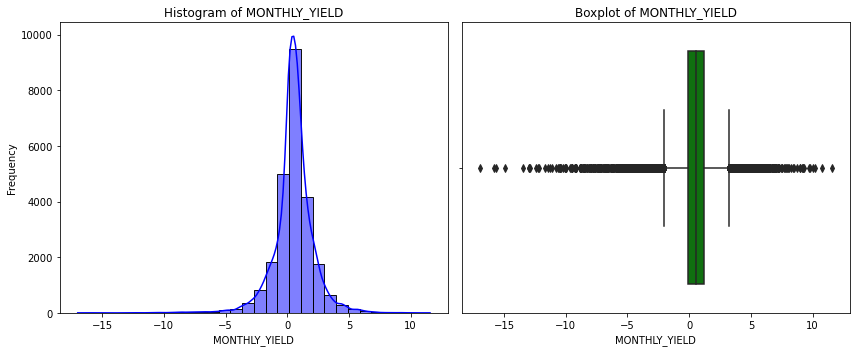

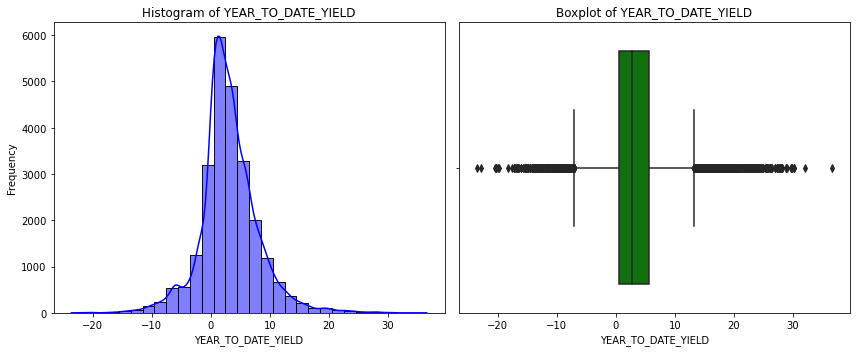

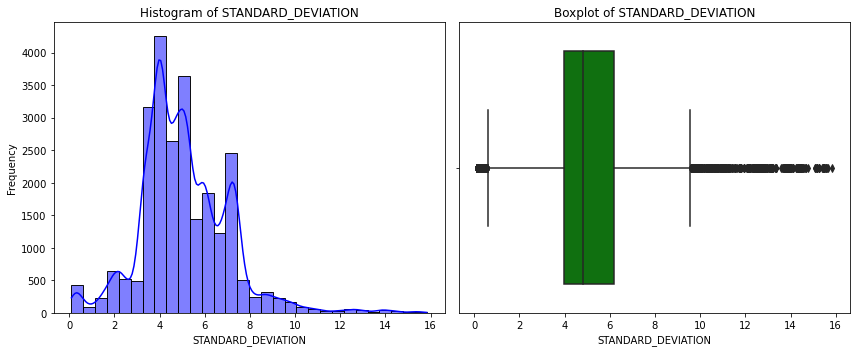

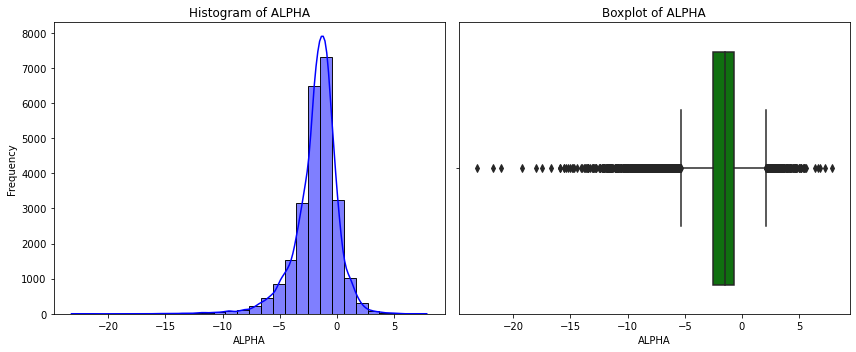

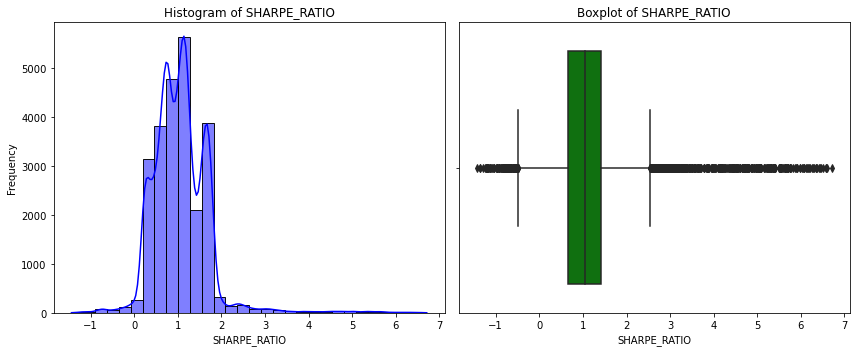

In [16]:
columns = ['TOTAL_ASSETS', 'AVG_ANNUAL_MANAGEMENT_FEE', 'AVG_DEPOSIT_FEE','MONTHLY_YIELD', 'YEAR_TO_DATE_YIELD', 'STANDARD_DEVIATION', 'ALPHA', 'SHARPE_RATIO']

for col in columns:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='green')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

The plots reveal significant variability in some features, such as TOTAL_ASSETS and MONTHLY_YIELD, with notable outliers and asymmetric distributions in certain variables. This indicates a need for outlier treatment and normalization before proceeding with further analysis.

#### Outliers & Anomalies

Outliers will be capped to the 1st and 99th percentiles, preserving data structure while reducing their impact on analysis-

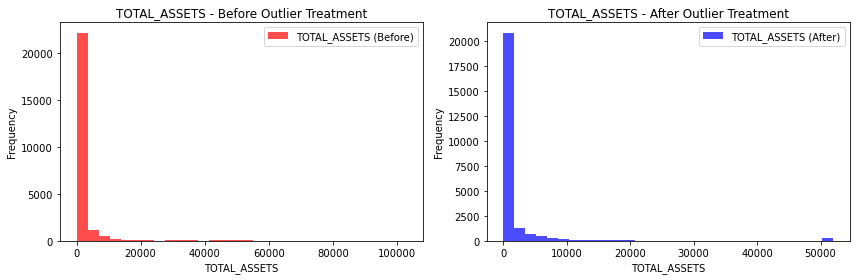

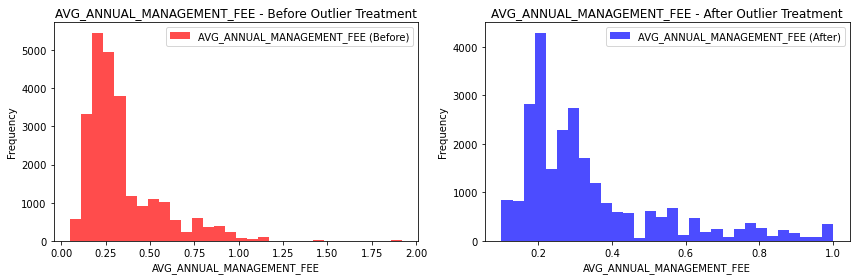

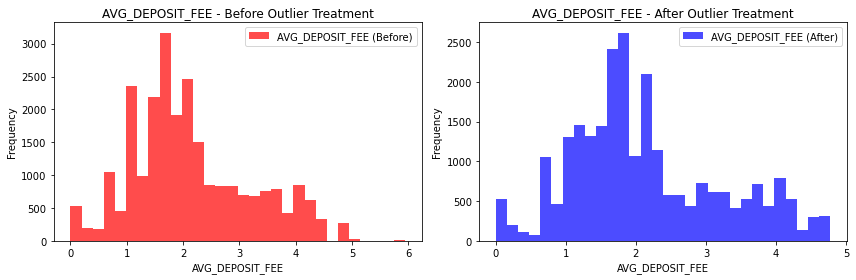

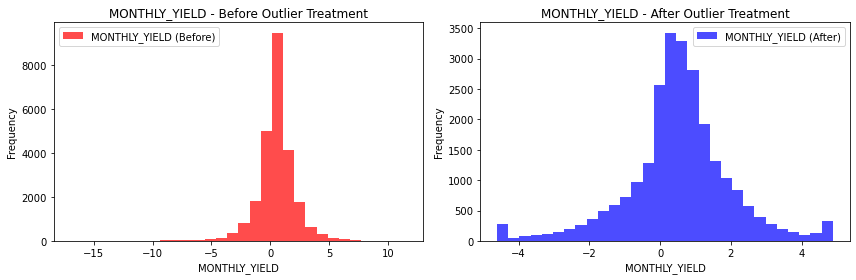

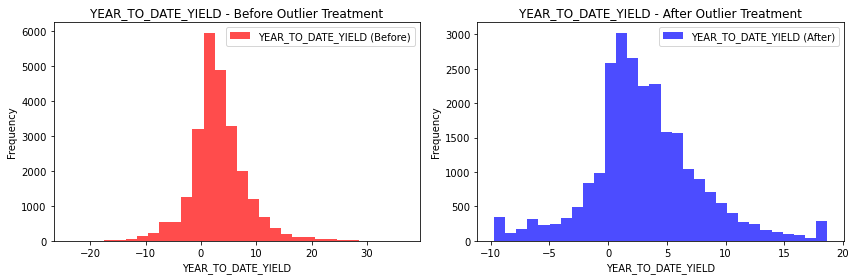

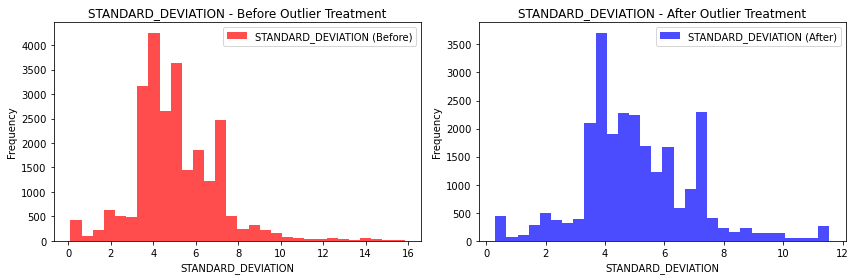

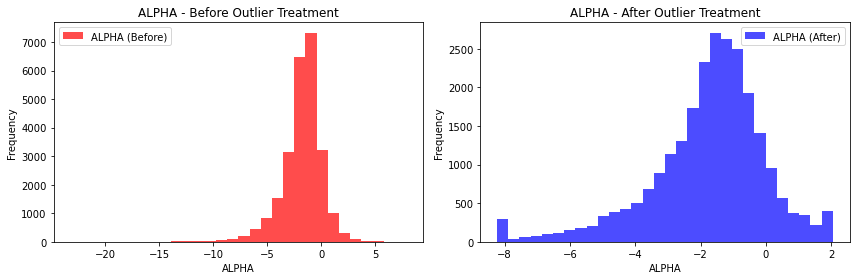

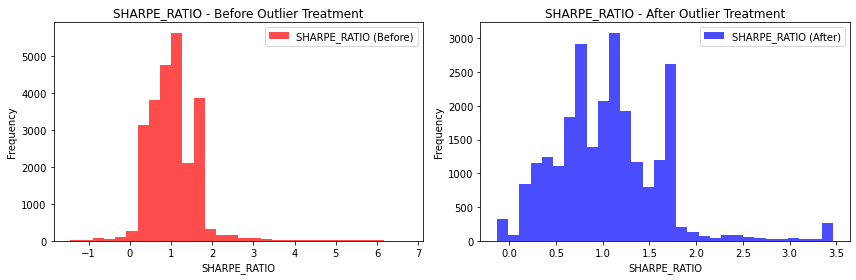

In [17]:
# Assisted by AI
original_df = df.copy()

def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

columns_to_check = ['TOTAL_ASSETS', 'AVG_ANNUAL_MANAGEMENT_FEE', 'AVG_DEPOSIT_FEE','MONTHLY_YIELD', 'YEAR_TO_DATE_YIELD', 'STANDARD_DEVIATION','ALPHA', 'SHARPE_RATIO']

# Apply capping to outliers
for col in columns_to_check:
    df = cap_outliers(df, col)

# Visualizations before and after
for col in columns_to_check:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(original_df[col], bins=30, color='red', alpha=0.7, label=f'{col} (Before)')
    plt.title(f'{col} - Before Outlier Treatment')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(df[col], bins=30, color='blue', alpha=0.7, label=f'{col} (After)')
    plt.title(f'{col} - After Outlier Treatment')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

Outliers were capped to the 1st and 99th percentiles, preserving data structure while reducing their impact on analysis.

Normalization is essential to ensure that all features are on a similar scale, preventing features with larger ranges from dominating the analysis or model performance.

#### Scaling

We selected numerical columns with varying scales, such as financial metrics, to ensure uniform scaling across features. This step prevents features with larger ranges from dominating the analysis and improves model performance in distance-based or scale-sensitive algorithms

The goal: ensure all columns have a mean close to 0 and a standard deviation close to 1-

In [18]:
columns_to_scale = ['TOTAL_ASSETS', 'AVG_ANNUAL_MANAGEMENT_FEE', 'AVG_DEPOSIT_FEE','MONTHLY_YIELD', 'YEAR_TO_DATE_YIELD', 'STANDARD_DEVIATION','SHARPE_RATIO', 'ALPHA']

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

#print(df_scaled[columns_to_scale].head()) -> Normalization was applied successfully

All features are now on a comparable scale, ensuring fair contributions to clustering, PCA, and other models. The scaling process effectively eliminated dominance by features with larger initial ranges.

The EDA process is now complete, including data cleaning, outlier treatment, normalization, and visualization. The dataset is well-prepared for subsequent modeling and analysis steps.

# Feature Selection and Engineering
<hr style="border:1px solid gray">

#### Feature Engineering

##### - Yield-to-Risk -

Creating the Yield-to-Risk feature to evaluate fund performance by measuring returns relative to risk-

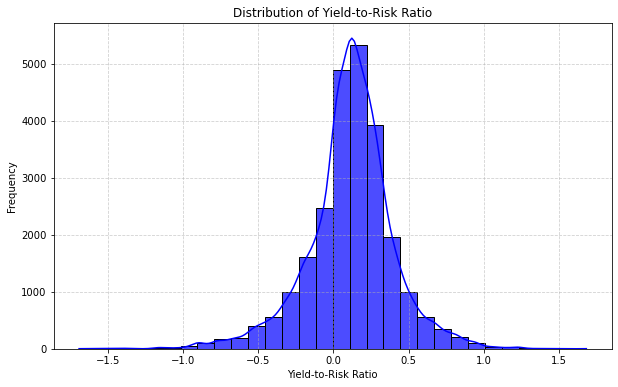

In [19]:
df['Yield_to_Risk'] = df['MONTHLY_YIELD'] / df['STANDARD_DEVIATION']
#print(df[['MONTHLY_YIELD', 'STANDARD_DEVIATION', 'Yield_to_Risk']].head())

plt.figure(figsize=(10, 6))
sns.histplot(df['Yield_to_Risk'], kde=True, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Yield-to-Risk Ratio')
plt.xlabel('Yield-to-Risk Ratio')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This feature helps identify funds with efficient risk management.

##### - Fund_Size_Category -

Adding a new column to categorize funds into size-based groups (Small, Medium, Large) based on their total assets-

This categorization allows us to analyze trends and the impact of fund size on performance.

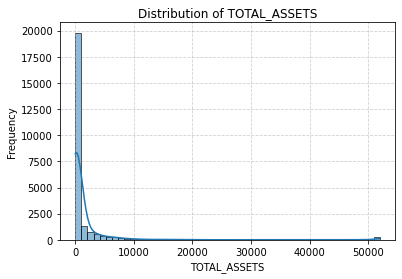

In [20]:
sns.histplot(df['TOTAL_ASSETS'], bins=50, kde=True)
plt.title('Distribution of TOTAL_ASSETS')
plt.xlabel('TOTAL_ASSETS')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [21]:
bins = [0, 200, 1000, float('inf')]
labels = ['Small', 'Medium', 'Large']

df['Fund_Size_Category'] = pd.cut(df['TOTAL_ASSETS'], bins=bins, labels=labels, include_lowest=True)
print(df['Fund_Size_Category'].value_counts())

Small     14802
Large      5259
Medium     4910
Name: Fund_Size_Category, dtype: int64


In [23]:
print(df.groupby('Fund_Size_Category')['Yield_to_Risk'].mean())

Fund_Size_Category
Small     0.104326
Medium    0.122996
Large     0.127643
Name: Yield_to_Risk, dtype: float64


The grouping is balanced and ensures sufficient data points in each category.
The categories include an adequate number of funds, allowing meaningful trend analysis without over-complicating the distribution.

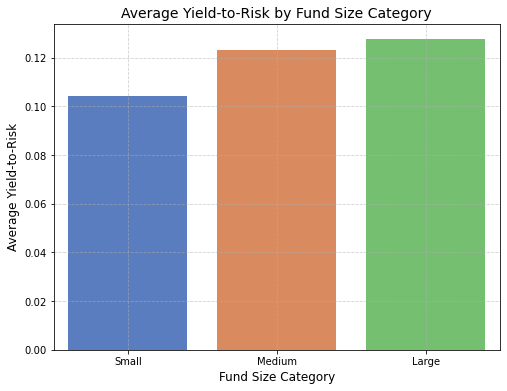

In [24]:
# Distribution of Yield-to-Risk by Fund Size Category
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Fund_Size_Category', y='Yield_to_Risk', estimator=np.mean, ci=None, palette='muted')
plt.title('Average Yield-to-Risk by Fund Size Category', fontsize=14)
plt.xlabel('Fund Size Category', fontsize=12)
plt.ylabel('Average Yield-to-Risk', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

General insight: Larger funds tend to have higher Yield-to-Risk ratios on average, indicating more efficient performance relative to their risk.
This trend suggests that fund size may positively influence performance, which can guide further analysis and recommendations.

##### - TA35 -

TA35 represents the performance of the 35 largest companies traded on the Tel Aviv Stock Exchange and serves as a key benchmark for the Israeli financial market.

We decided to include this feature in our dataset to capture its potential influence on fund performance, given its significant role in reflecting market trends and economic conditions.

In [28]:
ta35_data = pd.read_csv('ChartData.csv')

In [29]:
ta35_data.rename(columns={'INDEX': 'TA35_Index'}, inplace=True)

ta35_data['Date'] = pd.to_datetime(ta35_data['DATE'], format='%d/%m/%Y')
df['INCEPTION_DATE'] = pd.to_datetime(df['INCEPTION_DATE'], format='%Y-%m-%d')

df = df.merge(ta35_data[['Date', 'TA35_Index']], left_on='INCEPTION_DATE', right_on='Date', how='left')
df.drop(columns=['Date'], inplace=True)

In [30]:
df['TA35_Index'].isnull().sum()

8096

Creating a time-series visualization to analyze the trends of the TA35 Index over time for imputing missing values-

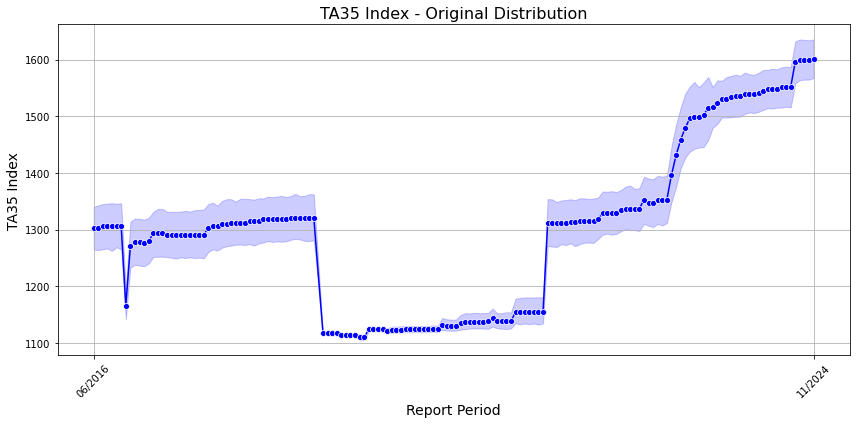

In [31]:
# 1. Original distribution (Before handling missing values)
x_ticks = [df['REPORT_PERIOD'].iloc[0], df['REPORT_PERIOD'].iloc[-1]]
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='REPORT_PERIOD', y='TA35_Index', marker='o', color='blue')
plt.title('TA35 Index - Original Distribution', fontsize=16)
plt.xlabel('Report Period', fontsize=14)
plt.ylabel('TA35 Index', fontsize=14)
plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The TA35 Index experienced significant declines due to major events, including the COVID-19 pandemic (2020), heightened security tensions in northern Israel (June 2024), and the outbreak of the "Iron Swords" war (October 2023), reflecting the impact of economic, political, and security crises on financial markets.

Therefore, instead of relying on trend and slope-based interpolation, we handled missing values using a moving average approach. For any remaining missing values, we used forward filling and backward filling techniques to ensure that all missing data was addressed seamlessly.

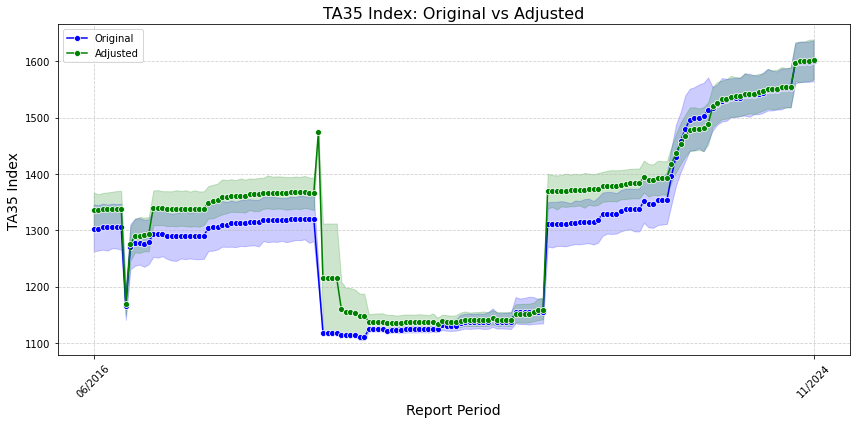

In [32]:
df_original = df.copy()
# Assisted by AI
df['TA35_Index'] = df['TA35_Index'].fillna(df['TA35_Index'].rolling(window=5, min_periods=1, center=True).mean())
df['TA35_Index'] = df['TA35_Index'].fillna(method='ffill').fillna(method='bfill')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_original, x='REPORT_PERIOD', y='TA35_Index', marker='o', color='blue', label='Original')
sns.lineplot(data=df, x='REPORT_PERIOD', y='TA35_Index', marker='o', color='green', label='Adjusted')

plt.title('TA35 Index: Original vs Adjusted', fontsize=16)
plt.xlabel('Report Period', fontsize=14)
plt.ylabel('TA35 Index', fontsize=14)
x_ticks = [df['REPORT_PERIOD'].iloc[0], df['REPORT_PERIOD'].iloc[-1]]
plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=45)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

We identified two apparent outliers in the TA35 Index after filling missing values. 

However, the method used for filling missing values respected the existing trends in the data. Given that this index is highly sensitive and trend-dependent, we decided to retain the visible outliers to preserve the natural flow and integrity of the overall trends.

#### Correlation Analysis: Exploring Relationships Between Variables

The heatmap will highlight feature correlations, helping identify relationships that may influence PCA and clustering, ensuring better preparation for dimensionality reduction:

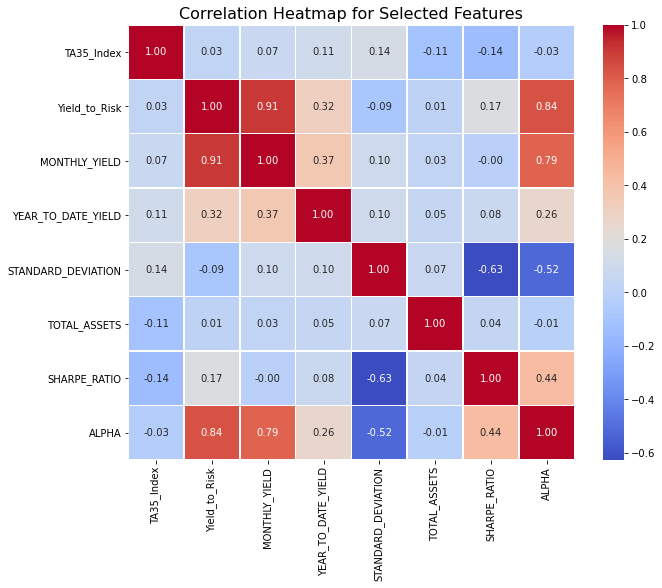

In [33]:
selected_columns = ['TA35_Index', 'Yield_to_Risk', 'MONTHLY_YIELD', 'YEAR_TO_DATE_YIELD', 'STANDARD_DEVIATION', 'TOTAL_ASSETS', 'SHARPE_RATIO', 'ALPHA']

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[selected_columns].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)
plt.title('Correlation Heatmap for Selected Features', fontsize=16)
plt.show()

We focused on these columns because they seemed the most relevant for understanding the data and what might influence fund behavior.

The analysis reveals strong correlations between key performance metrics like Yield_to_Risk and MONTHLY_YIELD (0.91) and ALPHA (0.84), highlighting their influence on fund performance. Weak correlations with the TA35_Index confirm its role as an independent economic indicator.

#### Dimensionality Reduction- PCA

We will use PCA to retain 95% of the dataset's variance, simplifying the data while preserving essential information for clustering and analysis. Choosing 95% ensures a balance between reducing dimensions and maintaining data complexity.

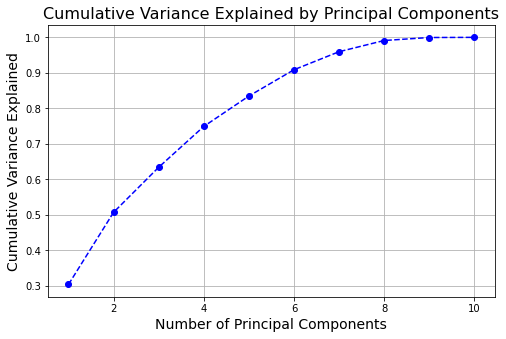

Number of components to retain: 7
        PC1       PC2       PC3       PC4       PC5       PC6       PC7
0  1.703531 -0.355824 -1.241841 -0.261669 -0.131423 -0.571510  0.882996
1 -1.202312  0.713832 -1.876999 -0.146394  0.504053  0.123757  1.007017
2  1.372865 -0.234105 -1.314097 -0.248514 -0.059083 -0.492413  0.897124
3  1.523167 -0.289432 -1.281236 -0.254463 -0.091941 -0.528382  0.890715
4  1.082280 -0.127140 -1.377598 -0.236961  0.004484 -0.422899  0.909536


In [34]:
# Assisted by AI
quantitative_columns = ['TOTAL_ASSETS', 'AVG_ANNUAL_MANAGEMENT_FEE', 'AVG_DEPOSIT_FEE','MONTHLY_YIELD', 'YEAR_TO_DATE_YIELD', 'STANDARD_DEVIATION','ALPHA', 'SHARPE_RATIO', 'Yield_to_Risk', 'TA35_Index'] 
# Categorical features were excluded as their numerical transformation would not provide meaningful insights for PCA in this context.

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[quantitative_columns])

pca = PCA()
pca_data = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Variance Explained by Principal Components', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Variance Explained', fontsize=14)
plt.grid()
plt.show()

n_components = (explained_variance >= 0.95).argmax() + 1
print(f"Number of components to retain: {n_components}")

pca_final = PCA(n_components=n_components)
transformed_data = pca_final.fit_transform(scaled_data)

pca_df = pd.DataFrame(transformed_data, columns=[f'PC{i+1}' for i in range(n_components)])
print(pca_df.head())

These scatter plots will visualize some of the relationships between the principal components, helping us identify potential patterns, groupings, or structures in the data after dimensionality reduction:

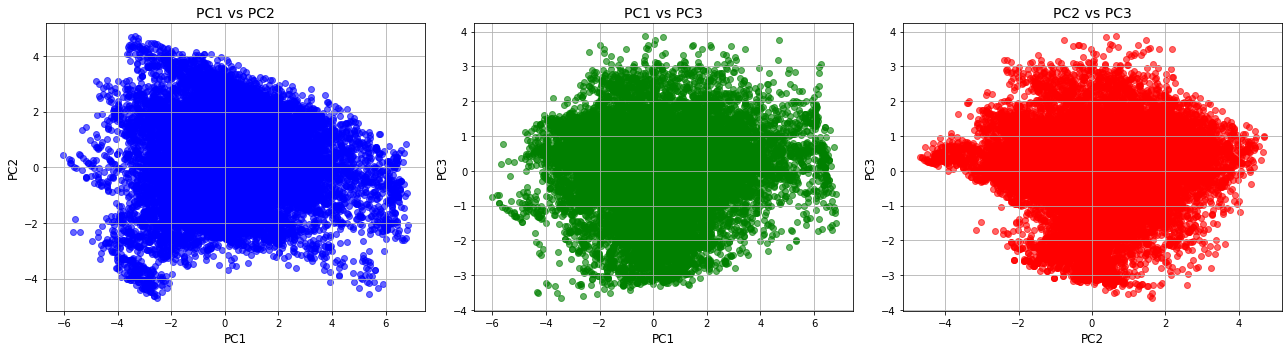

In [35]:
plt.figure(figsize=(18, 5))

# PC1 vs PC2
plt.subplot(1, 3, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, color='b')
plt.title('PC1 vs PC2', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.grid(True)

# PC1 vs PC3
plt.subplot(1, 3, 2)
plt.scatter(pca_df['PC1'], pca_df['PC3'], alpha=0.6, color='g')
plt.title('PC1 vs PC3', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC3', fontsize=12)
plt.grid(True)

# PC2 vs PC3
plt.subplot(1, 3, 3)
plt.scatter(pca_df['PC2'], pca_df['PC3'], alpha=0.6, color='r')
plt.title('PC2 vs PC3', fontsize=14)
plt.xlabel('PC2', fontsize=12)
plt.ylabel('PC3', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

The scatter plots reveal a well-distributed spread across the principal components, indicating no distinct clusters but a balanced representation of the data in the reduced dimensional space.

Interpreting Principal Component Loadings to Identify Key Drivers in the Dataset-

In [36]:
# Assisted by AI
# Access the PCA components (loadings)
loadings = pd.DataFrame(
    pca_final.components_,
    columns=quantitative_columns,
    index=[f'PC{i+1}' for i in range(n_components)]
)
#print(loadings)

Each Principal Component represents a linear combination of the original features, emphasizing different aspects of the dataset:

PC1: Overall performance and yield metrics.
PC2: Risk and variability.
PC3: Asset size vs. fees trade-off.
PC4: Stock exposure variability.
PC5: Annual yield and deposit fees.
PC6: Deposit fees and risk interplay.
PC7: Stock exposure and fee distribution.

# Modeling and Unsupervised Learning
<hr style="border:1px solid gray">

#### CLUSTERING

We will begin with KMeans and Hierarchical Clustering, as our initial exploration suggests the data is relatively structured with minimal noise. These algorithms are well-suited for such data, and we will evaluate if DBSCAN might be needed based on the results.

#### K-MEANS ALGORITHM:

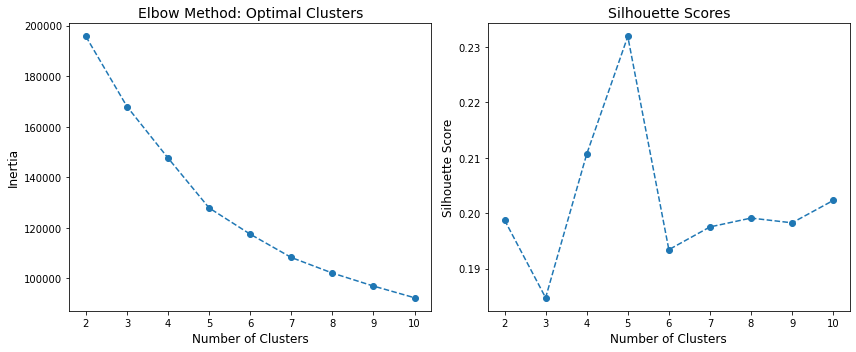

Optimal number of clusters: 5


In [37]:
# Using PCA-transformed data
data_for_clustering = pca_df  

# Assisted by AI
# Elbow Method
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)  # Testing from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_for_clustering)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_for_clustering, labels))

plt.figure(figsize=(12, 5))

# Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Optimal Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)

# Silhouette Scores Plot
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)

plt.tight_layout()
plt.show()

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # starts at 2 since k=1 lacks meaningful data division
print(f"Optimal number of clusters: {optimal_clusters}")

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_for_clustering['Cluster'] = kmeans.fit_predict(data_for_clustering)

df['Cluster'] = data_for_clustering['Cluster']

The Elbow point is approximately at 5 clusters, as the reduction in Inertia becomes less significant beyond this point. Additionally, the Silhouette Scores indicate that 5 clusters provide the best balance of compactness and separation, further supporting this choice.

In [38]:
print(df['Cluster'].value_counts())

1    9658
0    6331
4    4436
3    3889
2     657
Name: Cluster, dtype: int64


Most of the data points are concentrated in one dominant cluster, while the remaining clusters are relatively evenly distributed, forming smaller subgroups.

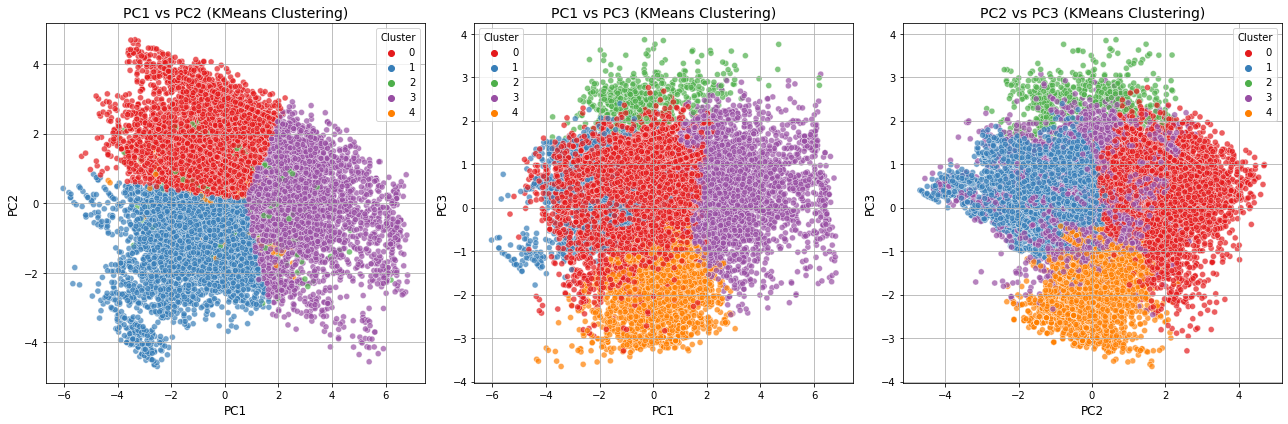

In [39]:
# Scatter plots for KMeans clustering
plt.figure(figsize=(18, 6))

# PC1 vs PC2
plt.subplot(1, 3, 1)
sns.scatterplot(
    x=data_for_clustering['PC1'], 
    y=data_for_clustering['PC2'], 
    hue=data_for_clustering['Cluster'], 
    palette='Set1',
    alpha=0.7
)
plt.title('PC1 vs PC2 (KMeans Clustering)', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)

# PC1 vs PC3
plt.subplot(1, 3, 2)
sns.scatterplot(
    x=data_for_clustering['PC1'], 
    y=data_for_clustering['PC3'], 
    hue=data_for_clustering['Cluster'], 
    palette='Set1',
    alpha=0.7
)
plt.title('PC1 vs PC3 (KMeans Clustering)', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC3', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)

# PC2 vs PC3
plt.subplot(1, 3, 3)
sns.scatterplot(
    x=data_for_clustering['PC2'], 
    y=data_for_clustering['PC3'], 
    hue=data_for_clustering['Cluster'], 
    palette='Set1',
    alpha=0.7
)
plt.title('PC2 vs PC3 (KMeans Clustering)', fontsize=14)
plt.xlabel('PC2', fontsize=12)
plt.ylabel('PC3', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)

plt.tight_layout()
plt.show()

The scatter plots visually confirm the clustering results. While some clusters are well-defined, others have overlapping regions. This suggests exploring the shared characteristics of overlapping clusters and verifying the findings using an additional clustering algorithm.

#### HIERARCHICAL CLUSTERING:

Based on our analysis with KMeans, where we identified 5 clusters as optimal using the Elbow Method, we applied the same number of clusters for Hierarchical Clustering to maintain consistency and ensure comparability.

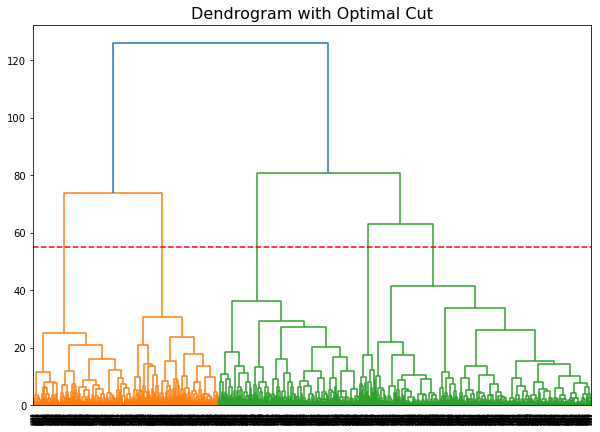

In [40]:
# Assisted by AI
# Using 10% of the data to make the dendrogram computation faster
subset_size = int(0.1 * len(pca_df))
pca_subset = pca_df.sample(n=subset_size, random_state=42)

linkage_matrix = shc.linkage(pca_subset, method='ward') # minimizing variance within clusters

plt.figure(figsize=(10, 7))
plt.title("Dendrogram with Optimal Cut", fontsize=16)
shc.dendrogram(linkage_matrix)
plt.axhline(y=55, color='r', linestyle='--')  # Cut line at y=55, indicating where we divide into 5 clusters
plt.show()

In [41]:
n_clusters = 5  # optimal using Silhouette score

hierarchical_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
labels_hierarchical = hierarchical_model.fit_predict(pca_df) # Using PCA-transformed data 

df['Cluster_Hierarchical'] = labels_hierarchical

print("Cluster Distribution (Hierarchical Clustering):")
print(df['Cluster_Hierarchical'].value_counts())

Cluster Distribution (Hierarchical Clustering):
0    9828
2    6142
3    4427
1    3908
4     666
Name: Cluster_Hierarchical, dtype: int64


Most of the data points are concentrated in one dominant cluster, while the remaining clusters are relatively evenly distributed, forming smaller subgroups.

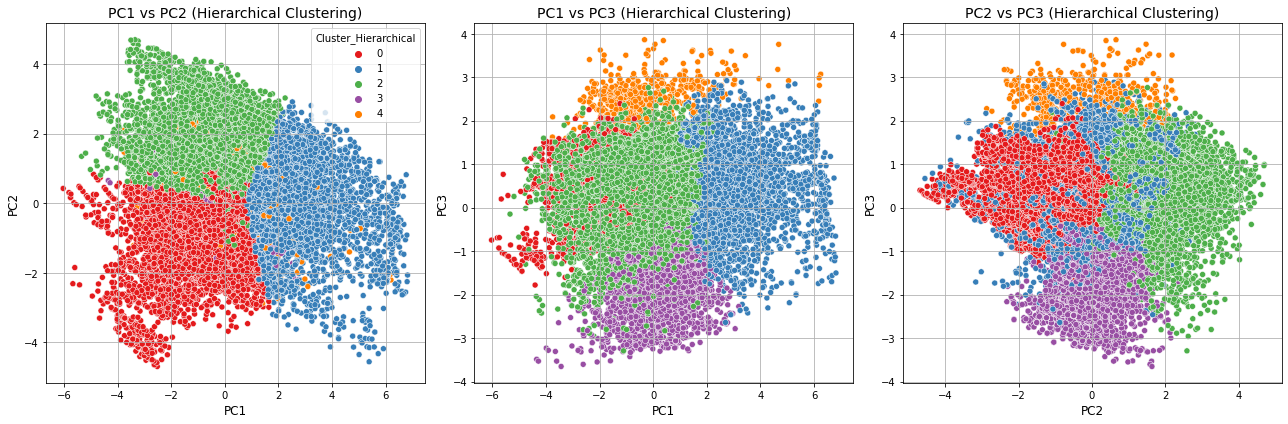

In [42]:
# Scatter plots for hierarchical clustering
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PC1 vs PC2
sns.scatterplot(
    ax=axes[0],
    x=pca_df['PC1'],
    y=pca_df['PC2'],
    hue=df['Cluster_Hierarchical'],
    palette='Set1',
    legend='full'
)
axes[0].set_title('PC1 vs PC2 (Hierarchical Clustering)', fontsize=14)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].grid(True)

# PC1 vs PC3
sns.scatterplot(
    ax=axes[1],
    x=pca_df['PC1'],
    y=pca_df['PC3'],
    hue=df['Cluster_Hierarchical'],
    palette='Set1',
    legend=None
)
axes[1].set_title('PC1 vs PC3 (Hierarchical Clustering)', fontsize=14)
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC3', fontsize=12)
axes[1].grid(True)

# PC2 vs PC3
sns.scatterplot(
    ax=axes[2],
    x=pca_df['PC2'],
    y=pca_df['PC3'],
    hue=df['Cluster_Hierarchical'],
    palette='Set1',
    legend=None
)
axes[2].set_title('PC2 vs PC3 (Hierarchical Clustering)', fontsize=14)
axes[2].set_xlabel('PC2', fontsize=12)
axes[2].set_ylabel('PC3', fontsize=12)
axes[2].grid(True)

plt.tight_layout()
plt.show()

The scatter plots for Hierarchical Clustering show identifiable clusters but with some overlap between them. This gives a general view of the data's structure, but the clusters are less defined than in KMeans, making it less suitable for detailed analysis.

#### Conclusion on Clustering Approach-

Given the well-defined and compact clusters identified by KMeans, it is the most suitable algorithm for our structured and noise-free dataset. While Hierarchical Clustering provides insights into the overall structure, DBSCAN is unnecessary as the data lacks significant noise or irregularly shaped clusters.

Therefore, we will proceed with the results of KMeans for further analysis.

### Observations and Improvements for Cluster Analysis:

These plots will highlight key feature variations across clusters to identify unique characteristics and will better interpret clustering results-

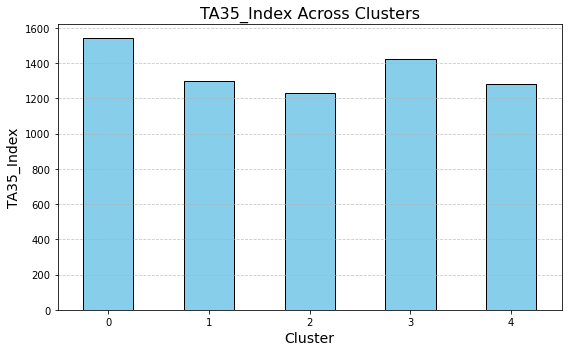

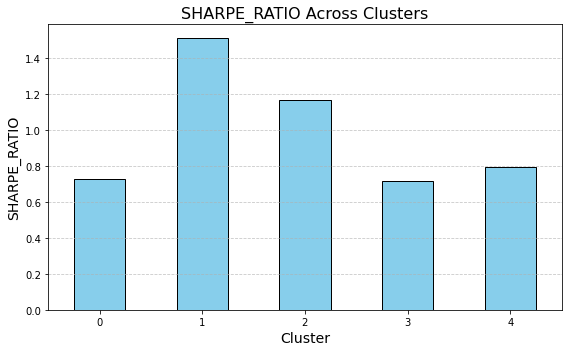

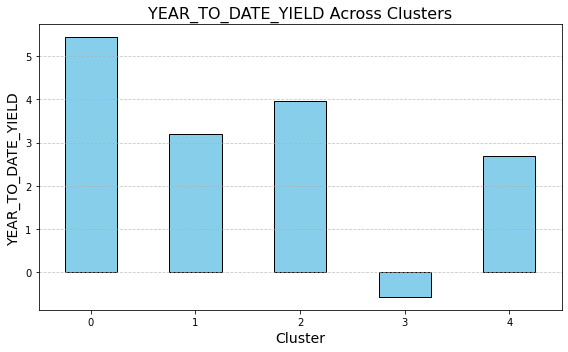

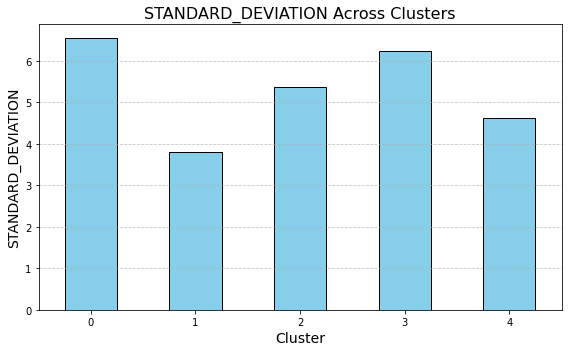

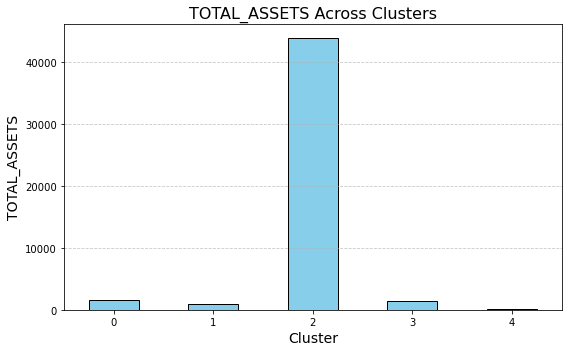

In [43]:
cluster_analysis = df.groupby('Cluster').mean()

metrics = ['TA35_Index', 'SHARPE_RATIO', 'YEAR_TO_DATE_YIELD', 'STANDARD_DEVIATION', 'TOTAL_ASSETS']

for metric in metrics:
        plt.figure(figsize=(8, 5))
        cluster_analysis[metric].plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'{metric} Across Clusters', fontsize=16)
        plt.xlabel('Cluster', fontsize=14)
        plt.ylabel(metric, fontsize=14)
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

The histograms reveal distinct cluster characteristics, such as high TA35_Index and Year-to-Date Yield in Cluster 0, superior risk-adjusted returns in Cluster 1 (high Sharpe ratio), higher volatility in Cluster 3, and a concentration of large portfolios in Cluster 2 (high total assets). These results highlight unique features of each cluster, helping to focus further analysis.

Visualizing the distribution of categorical variables across clusters to determine whether specific categories, such as fund size or classification, are more prevalent in certain clusters-

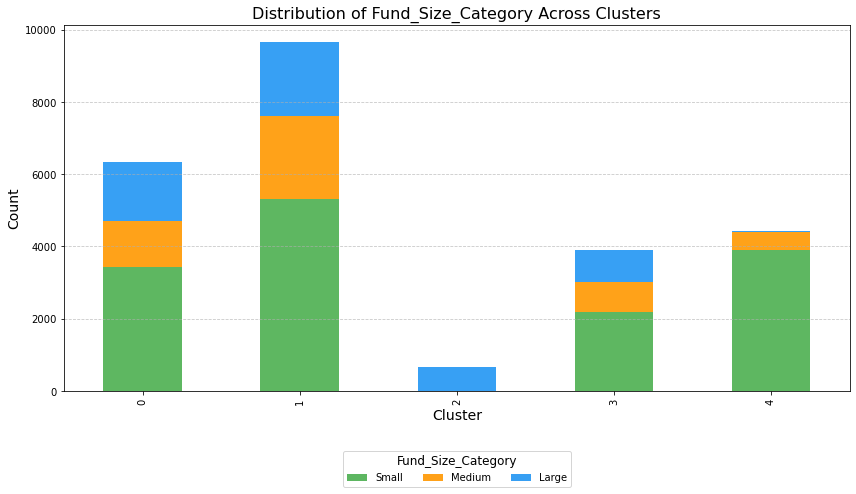

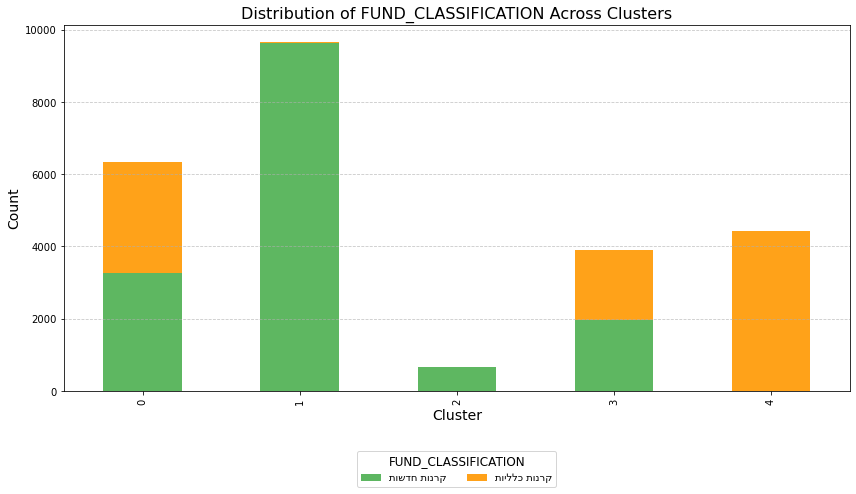

In [44]:
categorical_columns = ['Fund_Size_Category', 'FUND_CLASSIFICATION']

for col in categorical_columns:
    category_distribution = df.groupby(['Cluster', col]).size().unstack(fill_value=0)
    
    ax = category_distribution.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 7),
        alpha=0.9,
        color=['#4CAF50', '#FF9800', '#2196F3', '#FFC107', '#E91E63']  
    )
    plt.title(f"Distribution of {col} Across Clusters", fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    # Assisted by AI
    handles, labels = ax.get_legend_handles_labels()
    if col == 'FUND_CLASSIFICATION':  
        labels = [label[::-1] for label in labels]  # Reverse text for proper Hebrew display
    ax.legend(
        handles,
        labels,
        title=col,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15), 
        fontsize=10,
        title_fontsize=12,
        ncol=3 
    )
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

The clusters exhibit distinct characteristics: Cluster 1 is dominated by small, new funds, Cluster 2 focuses on large, new funds, Cluster 0 and 4 have a mix of fund sizes but differ in classification dominance, while Cluster 3 represents a balanced distribution of medium and general funds, highlighting clear segmentation based on fund size and classification.

##### This summary will highlight the characteristics of each cluster-

Cluster 0: High TA35 Index and Year-to-Date Yield with balanced risk-return, dominated by small-sized funds and a mix of new and general classifications.

Cluster 1: Exceptional Sharpe Ratio and low volatility, primarily consisting of small-sized, new funds.

Cluster 2: Defined by very large total assets, moderate performance, and a composition of large, new funds.

Cluster 3: High variability with balanced performance metrics, comprising medium-sized funds and general classifications.

Cluster 4: Average market performance with balanced risk-return, dominated by medium-sized funds leaning toward general classifications.

#### Classification

The classification models are used to predict the cluster membership for new data points, enabling us to group similar entities effectively as a foundation for building a recommendation system.

We selected a diverse set of classification algorithms, including linear (Logistic Regression), tree-based (Random Forest, Decision Tree), instance-based (K-Nearest Neighbors), and kernel-based (SVM) methods to cover a range of approaches and compare their performance.

In [47]:
# Assisted by AI
# The 'Cluster' column, derived from K-Means, is used as the target variable in classification to predict cluster membership for new data-
X = pca_df.drop(columns=['Cluster'])  
y = pca_df['Cluster'] 

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Perform cross-validation
cv_results = {
    name: cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)
    for name, model in models.items()
}

summary = pd.DataFrame({
    name: {
        'Mean Accuracy': scores['test_accuracy'].mean(),
        'Std Dev Accuracy': scores['test_accuracy'].std(),
        'Mean Precision': scores['test_precision'].mean(),
        'Mean Recall': scores['test_recall'].mean(),
        'Mean F1-Score': scores['test_f1'].mean(),
    }
    for name, scores in cv_results.items()
}).T

print(summary)

                     Mean Accuracy  Std Dev Accuracy  Mean Precision  \
Logistic Regression       0.972609          0.027138        0.975515   
Random Forest             0.941693          0.038992        0.949945   
SVM                       0.934005          0.047947        0.944374   
K-Nearest Neighbors       0.874897          0.070345        0.897109   
Decision Tree             0.929799          0.050993        0.937972   

                     Mean Recall  Mean F1-Score  
Logistic Regression     0.972609       0.972749  
Random Forest           0.941693       0.940526  
SVM                     0.934005       0.933709  
K-Nearest Neighbors     0.874897       0.872433  
Decision Tree           0.929799       0.928580  


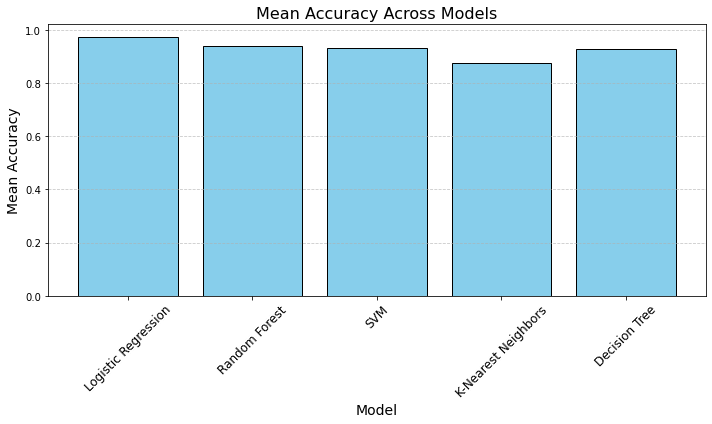

In [52]:
# Visualization of mean accuracy
model_names = list(cv_results.keys())
mean_accuracies = [cv_results[name]['test_accuracy'].mean() for name in model_names]

plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_accuracies, color='skyblue', edgecolor='black')
plt.title('Mean Accuracy Across Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Logistic Regression is the most suitable choice for our dataset due to its superior performance across all evaluation metrics: it achieved the highest mean accuracy (97.26%), precision (97.55%), recall (97.26%), and F1-score (97.27%) during cross-validation, along with the lowest standard deviation (2.71%), indicating consistent and reliable predictions across all folds.cy and consistency in cross-validation, so we chose it for further analysis and recommendations.

The selected model will form the backbone of the recommendation system by enabling accurate predictions of cluster memberships for new data points, ensuring relevant and personalized recommendations.

# Dynamic Recommendation System for Optimal Fund Selection
<hr style="border:1px solid gray">

In this phase, we aim to build a recommendation system that utilizes the results from clustering and classification models.

Our recommendation system prototype is based on a content-based filtering approach, where the user's specific preferences are directly collected and used to suggest three tailored funds that match their criteria.

In [53]:
# User input- the user provides their preferences, the values below are an example for demonstration purposes.
user_params = {
    'STANDARD_DEVIATION': 5.0,  # Risk Level 
    'TA35_Index': 1500,  # Exposure to TA35 Index
    'AVG_ANNUAL_MANAGEMENT_FEE': 0.3,  # Maximum Annual Management Fee
    'Fund_Size_Category': 'Small'  # Fund Size Category
}

Before using the recommendation system, users should provide the following:

Risk Level (STANDARD_DEVIATION): Suggested range: 0.5 to 10 (higher = higher risk)

Stock Exposure (TA35_Index): Suggested range: 1000 to 2000 (higher = more exposure)

Maximum Management Fee (AVG_ANNUAL_MANAGEMENT_FEE): Suggested range: 0.05 to 0.65 (lower = cheaper)

Fund Size Category (Fund_Size_Category): Options: ['Small', 'Medium', 'Large']

These inputs guide the system to predict the best cluster and recommend suitable funds.

In [54]:
# Assisted by AI
numeric_columns = ['STANDARD_DEVIATION', 'TA35_Index', 'AVG_ANNUAL_MANAGEMENT_FEE']
categorical_columns = ['Fund_Size_Category']

def preprocess_data(df):
    X_original = df[numeric_columns + categorical_columns]
    y = df['Cluster']  
    return train_test_split(X_original, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = preprocess_data(df)

# Encode categorical features and combine with numeric columns
def add_categorical_features(X_original, categorical_columns):
    return pd.concat([
        X_original[numeric_columns],
        pd.get_dummies(X_original[categorical_columns], drop_first=True)
    ], axis=1)

X_train_final = add_categorical_features(X_train, categorical_columns)
X_test_final = add_categorical_features(X_test, categorical_columns)

# Train the classification model (Logistic Regression)
def train_classification_model(X_train, y_train):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    return model

classification_model = train_classification_model(X_train_final, y_train)

# Predict the cluster
def predict_cluster(user_params, classification_model, X_train_columns, numeric_columns, categorical_columns):
    user_data = pd.DataFrame([user_params])
    user_data_final = pd.concat([
        user_data[numeric_columns],
        pd.get_dummies(user_data[categorical_columns], drop_first=True)
    ], axis=1)
    
    for col in set(X_train_columns) - set(user_data_final.columns):
        user_data_final[col] = 0
    user_data_final = user_data_final[X_train_columns]
    
    return classification_model.predict(user_data_final)[0]

# Recommend top funds based on user input
def recommend_funds(user_params, df, classification_model, X_train_columns):
    predicted_cluster = predict_cluster(
        user_params, classification_model, X_train_columns, numeric_columns, categorical_columns
    )
    
    # Filter funds based on cluster and user constraints
    filtered_funds = df[
        (df['Cluster'] == predicted_cluster) &
        (df['AVG_ANNUAL_MANAGEMENT_FEE'] <= user_params['AVG_ANNUAL_MANAGEMENT_FEE']) &
        (df['Fund_Size_Category'] == user_params['Fund_Size_Category'])
    ]
    
    # Add scoring mechanism for proximity to risk level and TA35_Index
    filtered_funds['Score'] = (
        abs(filtered_funds['STANDARD_DEVIATION'] - user_params['STANDARD_DEVIATION']) +
        abs(filtered_funds['TA35_Index'] - user_params['TA35_Index'])
    )
    
    # Rank funds by score, management fee, and risk level
    return (
        filtered_funds.sort_values(by=['Score', 'AVG_ANNUAL_MANAGEMENT_FEE', 'STANDARD_DEVIATION'])
        .drop_duplicates(subset='FUND_NAME')
        .head(3)  
    )

recommended_funds = recommend_funds(user_params, df, classification_model, X_train_final.columns)

Code Explanation:
The code takes user preferences as input, predicts the relevant cluster using a Logistic Regression model, and ranks funds within that cluster based on proximity to the user's risk level (STANDARD_DEVIATION) and stock exposure (TA35_Index). It also filters results based on management fees and fund size to ensure the recommendations align closely with user preferences.

In [55]:
print("\nTop recommended funds:")
recommended_funds[['FUND_NAME', 'PARENT_COMPANY_NAME', 'Fund_Size_Category', 'STANDARD_DEVIATION', 'TA35_Index', 'AVG_ANNUAL_MANAGEMENT_FEE']]


Top recommended funds:


,FUND_NAME,PARENT_COMPANY_NAME,Fund_Size_Category,STANDARD_DEVIATION,TA35_Index,AVG_ANNUAL_MANAGEMENT_FEE
18590,מנורה מבטחים פנסיה יעד לפרישה 2065,מנורה מבטחים פנסיה,Small,5.010077,1499.05,0.17
18681,"מנורה מבטחים פנסיה אשראי ואג""ח",מנורה מבטחים פנסיה,Small,5.010077,1499.05,0.17
18693,מנורה מבטחים פנסיה עוקב מדדי מניות,מנורה מבטחים פנסיה,Small,4.922674,1499.05,0.19


In [56]:
y_pred = classification_model.predict(X_test_final)

# Assisted by AI
# Evaluate the classification model
print("\nModel Evaluation:")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Evaluate recommendation accuracy
def evaluate_recommendation_accuracy(df, classification_model, X_test_final, y_test):
    y_pred = classification_model.predict(X_test_final)
    # Compare predicted vs actual clusters
    accuracy = (y_pred == y_test.values).mean()
    return accuracy

recommendation_accuracy = evaluate_recommendation_accuracy(df, classification_model, X_test_final, y_test)
print(f"\nRecommendation System Accuracy: {recommendation_accuracy:.2f}")


Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.76      0.68      1217
           1       0.81      0.91      0.86      1982
           2       0.26      0.08      0.12       115
           3       0.27      0.11      0.16       793
           4       0.89      0.91      0.90       888

    accuracy                           0.73      4995
   macro avg       0.57      0.56      0.54      4995
weighted avg       0.68      0.73      0.70      4995


Recommendation System Accuracy: 0.73


The current recommendation system achieves a satisfactory accuracy of 73% with strong performance for dominant clusters. However, addressing imbalances and improving representation for smaller clusters could enhance the system's robustness and provide more consistent recommendations.

This is a preliminary prototype designed to demonstrate the potential of a recommendation system for investment funds. While it is currently limited to user-provided input, it highlights the foundation of a personalized recommendation engine.

# Final Summary

In this project, we analyzed financial fund data using clustering (KMeans, Hierarchical) to group funds and classification (Logistic Regression) to predict clusters. As a supplementary feature, we developed a prototype recommendation system to match user preferences with funds, showcasing the potential of data-driven solutions for decision-making and laying the groundwork for future improvements.